### Machine Learning Workflow

This notebook approaches time series forecasting in a number of steps:
* Loading and exploring the data
* Creating training and test sets of time series
* Formatting data as JSON files and uploading to S3
* Instantiating and training a DeepAR estimator
* Deploying a model and creating a predictor
* Evaluating the predictor 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json
import os 
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.estimator import Estimator

In [2]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()


In [3]:
ltc_df = pd.read_csv('Data/ltc.csv')

In [4]:
ltc_3yr = ltc_df[2003:]

In [5]:
ltc_3yr.head()

,date,AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,...,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d
2003,2017-04-01,31607,602,4702263,7811.068106,1.220910,3.835566e+08,3.141564e+08,87460.092017,0.003258,...,1.787616e+07,176.263868,1340.179909,0.012416,0.094400,5.789916e+06,4.402223e+07,0.051749,0.106791,0.076611
2004,2017-04-02,26028,593,5353315,9027.512648,1.322647,4.199110e+08,3.174778e+08,87420.907407,0.002861,...,1.477252e+07,368.518821,3066.618541,0.203401,1.692593,8.153110e+06,6.784587e+07,0.052145,0.107506,0.077270
2005,2017-04-03,19696,635,5222384,8224.226772,1.341931,4.299101e+08,3.203666e+08,87420.907407,0.002921,...,2.039428e+07,356.530024,3036.546191,0.519780,4.426937,7.443634e+06,6.339701e+07,0.052164,0.107153,0.077284
2006,2017-04-04,16274,654,4732539,7236.298165,1.397432,4.614412e+08,3.302066e+08,91264.147893,0.002666,...,3.770598e+07,557.767370,5097.238889,0.826968,7.557366,9.683957e+06,8.849826e+07,0.052392,0.107359,0.077552
2007,2017-04-05,24797,598,6757351,11299.918060,1.765644,6.248041e+08,3.538675e+08,92957.205376,0.003474,...,5.193713e+07,693.664944,8580.855234,0.734800,9.089709,1.962725e+07,2.427953e+08,0.056904,0.118530,0.086020


In [6]:
ltc_3yr.index = ltc_3yr['date']

In [7]:
ltc_3yr.head()

,date,AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,...,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d
date,,,,,,,,,,,,,,,,,,,,,
2017-04-01,2017-04-01,31607,602,4702263,7811.068106,1.220910,3.835566e+08,3.141564e+08,87460.092017,0.003258,...,1.787616e+07,176.263868,1340.179909,0.012416,0.094400,5.789916e+06,4.402223e+07,0.051749,0.106791,0.076611
2017-04-02,2017-04-02,26028,593,5353315,9027.512648,1.322647,4.199110e+08,3.174778e+08,87420.907407,0.002861,...,1.477252e+07,368.518821,3066.618541,0.203401,1.692593,8.153110e+06,6.784587e+07,0.052145,0.107506,0.077270
2017-04-03,2017-04-03,19696,635,5222384,8224.226772,1.341931,4.299101e+08,3.203666e+08,87420.907407,0.002921,...,2.039428e+07,356.530024,3036.546191,0.519780,4.426937,7.443634e+06,6.339701e+07,0.052164,0.107153,0.077284
2017-04-04,2017-04-04,16274,654,4732539,7236.298165,1.397432,4.614412e+08,3.302066e+08,91264.147893,0.002666,...,3.770598e+07,557.767370,5097.238889,0.826968,7.557366,9.683957e+06,8.849826e+07,0.052392,0.107359,0.077552
2017-04-05,2017-04-05,24797,598,6757351,11299.918060,1.765644,6.248041e+08,3.538675e+08,92957.205376,0.003474,...,5.193713e+07,693.664944,8580.855234,0.734800,9.089709,1.962725e+07,2.427953e+08,0.056904,0.118530,0.086020


In [8]:
ltc_3yr = ltc_3yr.drop(labels='date', axis=1)

In [9]:
ltc_3yr = ltc_3yr.drop(labels='PriceBTC', axis=1)

In [10]:
ltc_3yr.insert(loc=0, column='Price', value=ltc_3yr['PriceUSD'], allow_duplicates=True)

In [11]:
ltc_3yr = ltc_3yr.drop(labels='PriceUSD', axis=1)

In [12]:
q = {'2017-04-01': 89, '2017-07-01': 90, '2017-10-01': 91, '2018-01-01': 91, '2018-04-01': 89, '2018-07-01': 90, \
     '2018-10-01': 91, '2019-01-01': 91, '2019-04-01': 89, '2019-07-01': 90}

In [13]:
time_series = []

start_idx = 0

for i in q:
    end_idx = start_idx + q[i] + 1
    
    data = ltc_3yr[:][start_idx:end_idx]

    time_series.append(pd.DataFrame(data=data))
    
    start_idx = end_idx

In [14]:
q2_2017 = pd.DataFrame(time_series[0])
q3_2017 = pd.DataFrame(time_series[1])
q4_2017 = pd.DataFrame(time_series[2])
q1_2018 = pd.DataFrame(time_series[3])
q2_2018 = pd.DataFrame(time_series[4])
q3_2018 = pd.DataFrame(time_series[5])
q4_2018 = pd.DataFrame(time_series[6])
q1_2019 = pd.DataFrame(time_series[7])
q2_2019 = pd.DataFrame(time_series[8])
q3_2019 = pd.DataFrame(time_series[9])

In [15]:
quarters = [q2_2017,q3_2017,q4_2017,q1_2018,q2_2018,q3_2018,q4_2018,q1_2019,q2_2019,q3_2019]

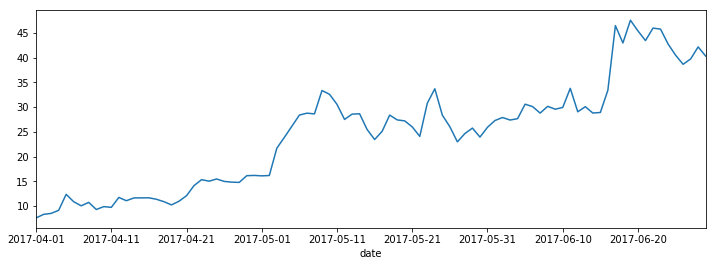

In [16]:
plt.figure(figsize=(12,4))
quarters[0]['Price'].plot()
plt.show()

In [17]:
q2_2017_train = pd.DataFrame(time_series[0][:-30])
q3_2017_train = pd.DataFrame(time_series[1][:-30])
q4_2017_train = pd.DataFrame(time_series[2][:-30])
q1_2018_train = pd.DataFrame(time_series[3][:-30])
q2_2018_train = pd.DataFrame(time_series[4][:-30])
q3_2018_train = pd.DataFrame(time_series[5][:-30])
q4_2018_train = pd.DataFrame(time_series[6][:-30])
q1_2019_train = pd.DataFrame(time_series[7][:-30])
q2_2019_train = pd.DataFrame(time_series[8][:-30])
q3_2019_train = pd.DataFrame(time_series[9][:-30])

In [18]:
quarters_training = [q2_2017_train,q3_2017_train,q4_2017_train,q1_2018_train,q2_2018_train,q3_2018_train,
                     q4_2018_train,q1_2019_train,q2_2019_train,q3_2019_train]

In [19]:
xlabels = ['2017-04-01','2017-04-11','2017-04-21','2017-05-01','2017-05-11','2017-05-21','2017-05-31','2017-06-10','2017-06-20']

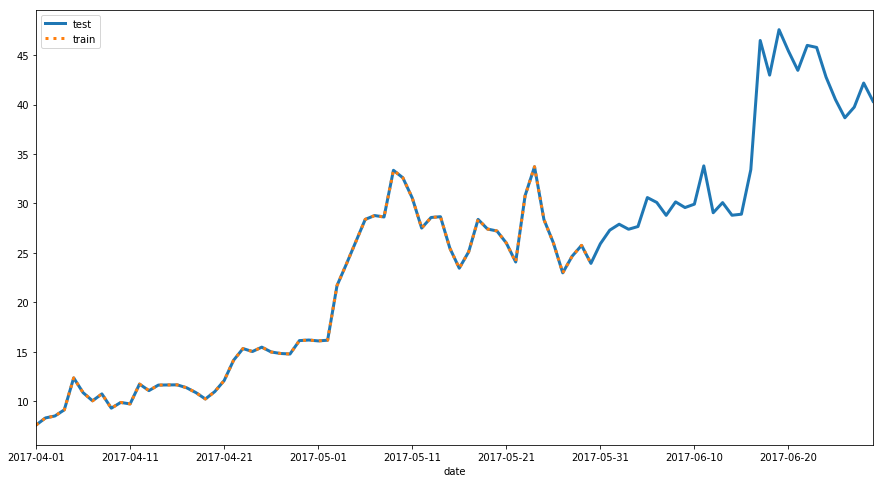

In [20]:
plt.figure(figsize=(15,8))
# test data is the whole time series
quarters[0]['Price'].plot(label='test', lw=3)
# train data is all but the last prediction pts
quarters_training[0]['Price'].plot(label='train', ls=':', lw=3)
plt.xticks(np.arange(90, step=10), xlabels)
plt.legend()
plt.show()

In [21]:
def series_to_json_obj(ts):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    ts_labels = ts.columns.values[1:]
    dynamic_feat = []
    
    for i in range(len(ts_labels)):
        dynamic_feat.append(list(ts[ts.columns.values[i]]))
    
    # get start time and target from the time series, ts
    json_obj = {"start": str(ts.index[0]), "target": list(ts['Price']), "dynamic_feat": dynamic_feat}
    return json_obj


In [22]:
series_to_json_obj(quarters[1])

{'start': '2017-06-30',
 'target': [39.369128254076706,
  38.1163571232574,
  41.617455616226394,
  45.708711580536395,
  54.4523606456279,
  53.248043504381,
  51.40006913638761,
  46.350343786792294,
  51.6587449913222,
  48.754163593537704,
  44.0230875686742,
  44.0946844839085,
  46.731747807854795,
  45.504595819607,
  42.614295927143104,
  38.5651422356585,
  40.7532560471325,
  42.3545210340915,
  43.5155672829493,
  39.970670489419796,
  44.5346130283284,
  45.3900137120577,
  46.995724018766005,
  45.1371263690174,
  44.889682047008705,
  42.008072583693206,
  41.9145169899964,
  41.7955063748825,
  40.0706591216819,
  40.980801656283795,
  40.288620206751496,
  42.245006213968296,
  43.1233744223086,
  41.571807092631005,
  42.550513470047996,
  43.10718762375279,
  45.9521064955457,
  45.3380507828088,
  45.90246267723829,
  49.1797753796553,
  47.65650380781221,
  47.3241376146049,
  47.0106506441056,
  46.2759343627748,
  45.146257144645396,
  45.517545259356396,
  43.105

In [23]:
def write_json_dataset(time_series, filename): 
    with open(filename, 'wb') as f:
        # for each of our times series, there is one JSON line
        for ts in range(len(time_series)):
            json_line = json.dumps(series_to_json_obj(time_series[ts])) + '\n'
            json_line = json_line.encode('utf-8')
        
            f.write(json_line)
    print(filename + ' saved.')

In [110]:
# save this data to a local directory
data_dir = 'deep_ar_quarters'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [111]:
# directories to save train/test data
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

# write train/test JSON files
write_json_dataset(quarters_training, train_key)        
write_json_dataset(quarters, test_key)

deep_ar_quarters/train.json saved.
deep_ar_quarters/test.json saved.


## Uploading Data to S3

Next, to make this data accessible to an estimator, I'll upload it to S3.


In [112]:
# general prefix
prefix='deepar-ltc'

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)

In [113]:
# check locations
print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-us-east-1-561941966718/deepar-ltc/train/train.json
Test data is stored in: s3://sagemaker-us-east-1-561941966718/deepar-ltc/test/test.json


# Training a DeepAR Estimator

Some estimators have specific, SageMaker constructors, but not all. Instead you can create a base `Estimator` and pass in the specific image (or container) that holds a specific model.

Next, we configure the container image to be used for the region that we are running in.

In [114]:
image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image


In [115]:
# dir to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

# instantiate a DeepAR estimator
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

In [116]:
freq='D'
context_length=30 # same as prediction_length

hyperparameters = {
    "epochs": "50",
    "time_freq": freq,
    "prediction_length": str(30),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

In [117]:
# set the hyperparams
estimator.set_hyperparameters(**hyperparameters)

In [118]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

2019-12-20 16:22:14 Starting - Starting the training job...
2019-12-20 16:22:15 Starting - Launching requested ML instances......
2019-12-20 16:23:20 Starting - Preparing the instances for training......
2019-12-20 16:24:24 Downloading - Downloading input data...
2019-12-20 16:25:10 Training - Training image download completed. Training in progress..Arguments: train
[12/20/2019 16:25:13 INFO 139931045447488] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience':

[12/20/2019 16:25:22 INFO 139931045447488] Epoch[3] Batch[0] avg_epoch_loss=3.312783
[12/20/2019 16:25:22 INFO 139931045447488] #quality_metric: host=algo-1, epoch=3, batch=0 train loss <loss>=3.31278276443
[12/20/2019 16:25:22 INFO 139931045447488] Epoch[3] Batch[5] avg_epoch_loss=3.148981
[12/20/2019 16:25:22 INFO 139931045447488] #quality_metric: host=algo-1, epoch=3, batch=5 train loss <loss>=3.14898145199
[12/20/2019 16:25:22 INFO 139931045447488] Epoch[3] Batch [5]#011Speed: 702.85 samples/sec#011loss=3.148981
[12/20/2019 16:25:23 INFO 139931045447488] Epoch[3] Batch[10] avg_epoch_loss=3.108501
[12/20/2019 16:25:23 INFO 139931045447488] #quality_metric: host=algo-1, epoch=3, batch=10 train loss <loss>=3.05992512703
[12/20/2019 16:25:23 INFO 139931045447488] Epoch[3] Batch [10]#011Speed: 695.64 samples/sec#011loss=3.059925
[12/20/2019 16:25:23 INFO 139931045447488] processed a total of 1284 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2259.500026702881, "sum":

[12/20/2019 16:25:41 INFO 139931045447488] Epoch[12] Batch[0] avg_epoch_loss=2.437734
[12/20/2019 16:25:41 INFO 139931045447488] #quality_metric: host=algo-1, epoch=12, batch=0 train loss <loss>=2.43773412704
[12/20/2019 16:25:42 INFO 139931045447488] Epoch[12] Batch[5] avg_epoch_loss=2.520997
[12/20/2019 16:25:42 INFO 139931045447488] #quality_metric: host=algo-1, epoch=12, batch=5 train loss <loss>=2.52099748453
[12/20/2019 16:25:42 INFO 139931045447488] Epoch[12] Batch [5]#011Speed: 675.15 samples/sec#011loss=2.520997
[12/20/2019 16:25:43 INFO 139931045447488] Epoch[12] Batch[10] avg_epoch_loss=2.502399
[12/20/2019 16:25:43 INFO 139931045447488] #quality_metric: host=algo-1, epoch=12, batch=10 train loss <loss>=2.48008141518
[12/20/2019 16:25:43 INFO 139931045447488] Epoch[12] Batch [10]#011Speed: 706.04 samples/sec#011loss=2.480081
[12/20/2019 16:25:43 INFO 139931045447488] processed a total of 1321 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2356.152057647705

[12/20/2019 16:25:52 INFO 139931045447488] processed a total of 1275 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2068.382978439331, "sum": 2068.382978439331, "min": 2068.382978439331}}, "EndTime": 1576859152.371569, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1576859150.303067}

[12/20/2019 16:25:52 INFO 139931045447488] #throughput_metric: host=algo-1, train throughput=616.377947202 records/second
[12/20/2019 16:25:52 INFO 139931045447488] #progress_metric: host=algo-1, completed 34 % of epochs
[12/20/2019 16:25:52 INFO 139931045447488] #quality_metric: host=algo-1, epoch=16, train loss <loss>=2.36692509651
[12/20/2019 16:25:52 INFO 139931045447488] best epoch loss so far
[12/20/2019 16:25:52 INFO 139931045447488] Saved checkpoint to "/opt/ml/model/state_fefb7cbe-ac81-4b5f-b83a-2d31990d36e4-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 27.01401710510254, "sum": 27.014017105102

[12/20/2019 16:26:01 INFO 139931045447488] Epoch[21] Batch[0] avg_epoch_loss=2.663539
[12/20/2019 16:26:01 INFO 139931045447488] #quality_metric: host=algo-1, epoch=21, batch=0 train loss <loss>=2.66353869438
[12/20/2019 16:26:02 INFO 139931045447488] Epoch[21] Batch[5] avg_epoch_loss=2.554160
[12/20/2019 16:26:02 INFO 139931045447488] #quality_metric: host=algo-1, epoch=21, batch=5 train loss <loss>=2.55416023731
[12/20/2019 16:26:02 INFO 139931045447488] Epoch[21] Batch [5]#011Speed: 711.83 samples/sec#011loss=2.554160
[12/20/2019 16:26:03 INFO 139931045447488] processed a total of 1265 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2122.8559017181396, "sum": 2122.8559017181396, "min": 2122.8559017181396}}, "EndTime": 1576859163.583497, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1576859161.460209}

[12/20/2019 16:26:03 INFO 139931045447488] #throughput_metric: host=algo-1, train throughput=595.86023493 records

#metrics {"Metrics": {"model.score.time": {"count": 1, "max": 3948.133945465088, "sum": 3948.133945465088, "min": 3948.133945465088}}, "EndTime": 1576859185.395812, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1576859181.447757}

[12/20/2019 16:26:25 INFO 139931045447488] #test_score (algo-1, RMSE): 61.5086951583
[12/20/2019 16:26:25 INFO 139931045447488] #test_score (algo-1, mean_wQuantileLoss): 0.3137727
[12/20/2019 16:26:25 INFO 139931045447488] #test_score (algo-1, wQuantileLoss[0.1]): 0.18435134
[12/20/2019 16:26:25 INFO 139931045447488] #test_score (algo-1, wQuantileLoss[0.2]): 0.24517319
[12/20/2019 16:26:25 INFO 139931045447488] #test_score (algo-1, wQuantileLoss[0.3]): 0.2858909
[12/20/2019 16:26:25 INFO 139931045447488] #test_score (algo-1, wQuantileLoss[0.4]): 0.31767994
[12/20/2019 16:26:25 INFO 139931045447488] #test_score (algo-1, wQuantileLoss[0.5]): 0.34143174
[12/20/2019 16:26:25 INFO 139931045447488] #test_score (a

In [119]:
%%time

# create a predictor
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    content_type="application/json" # specify that it will accept/produce JSON
)

---------------------------------------------------------------------------------------------------------------------------!CPU times: user 617 ms, sys: 47.7 ms, total: 664 ms
Wall time: 10min 21s


In [44]:
def series_to_json_obj_predict(ts, ts_test):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    ts_labels = ts.columns.values[1:]
    dynamic_feat = []
    
    for i in range(len(ts_labels)):
        dynamic_feat.append(list(ts_test[ts_test.columns.values[i]]))
    
    # get start time and target from the time series, ts
    json_obj = {"start": str(ts.index[0]), "target": list(ts['Price']), "dynamic_feat": dynamic_feat}
    return json_obj


In [121]:
len(series_to_json_obj_predict(quarters_training[0],quarters[0])['dynamic_feat'][0])

90

In [37]:
def json_predictor_input(input_ts, target_ts, num_samples=50, quantiles=['0.1', '0.5', '0.9']):
    '''Accepts a list of input time series and produces a formatted input.
       :input_ts: An list of input time series.
       :num_samples: Number of samples to calculate metrics with.
       :quantiles: A list of quantiles to return in the predicted output.
       :return: The JSON-formatted input.
       '''
    # request data is made of JSON objects (instances)
    # and an output configuration that details the type of data/quantiles we want
    
    instances = []
    for k in range(len(input_ts)):
        # get JSON objects for input time series
        instances.append(series_to_json_obj_predict(input_ts[k], target_ts[k]))
    # specify the output quantiles and samples
    configuration = {"num_samples": num_samples, 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}

    json_request = json.dumps(request_data).encode('utf-8')
    
    return json_request

In [123]:
# get all input and target (test) time series
input_ts = quarters_training
target_ts = quarters

# get formatted input time series
json_input_ts = json_predictor_input(input_ts, target_ts)

# get the prediction from the predictor
json_prediction = predictor.predict(json_input_ts)


In [124]:
print(json_prediction)

b'{"predictions":[{"quantiles":{"0.1":[31.8817119598,15.2558965683,24.1828746796,32.9449119568,32.0192718506,32.6371536255,33.6665992737,31.5734577179,31.8424606323,33.6322631836,33.2298431396,29.5673007965,34.3452568054,32.7611579895,33.1420288086,31.8121414185,31.5539360046,25.8923301697,25.15366745,24.1749744415,17.5065498352,27.2782058716,31.9686183929,26.3873977661,29.1113700867,24.5652999878,24.1391201019,29.8177928925,32.4871139526,32.4430236816],"0.9":[42.7508277893,43.2625808716,35.3489532471,44.0261917114,42.0133132935,42.0384407043,40.1638679504,39.6963577271,41.9122695923,42.0797348022,43.6391716003,41.4569740295,43.5832366943,43.9219322205,44.914440155,43.9282417297,43.3775253296,47.2571563721,45.9980392456,55.2073554993,55.6073074341,47.9397888184,49.4471931458,49.6566200256,48.9347343445,41.0376358032,37.6327552795,42.2073669434,43.8484687805,46.2307548523],"0.5":[36.3493270874,25.4043426514,30.7700119019,38.6807174683,37.7428436279,37.2508735657,36.9438819885,35.2224121

In [38]:
# helper function to decode JSON prediction
def decode_prediction(prediction, encoding='utf-8'):
    '''Accepts a JSON prediction and returns a list of prediction data.
    '''
    prediction_data = json.loads(prediction.decode(encoding))
    prediction_list = []
    for k in range(len(prediction_data['predictions'])):
        prediction_list.append(pd.DataFrame(data=prediction_data['predictions'][k]['quantiles']))
    return prediction_list

In [126]:
# get quantiles/predictions
prediction_list = decode_prediction(json_prediction)

# should get a list of 30 predictions 
# with corresponding quantile values
print(prediction_list[1])

          0.1        0.9        0.5
0   50.721146  62.838577  56.650230
1   48.195412  59.324612  53.734676
2   56.584293  72.959953  62.690117
3   41.722248  60.693245  53.182556
4   52.274868  65.507545  59.428032
5   50.929810  57.882439  53.317638
6   49.174568  58.430481  54.672321
7   45.932556  58.357754  51.729019
8   48.763763  62.403622  56.286144
9   49.161434  55.958195  53.093449
10  48.866425  58.485168  53.230659
11  46.113403  56.864700  50.576424
12  46.090500  55.153515  50.748631
13  44.776352  54.237495  49.641773
14  46.933220  55.739323  51.350739
15  42.035259  52.946125  46.154221
16  40.455154  53.865810  46.101364
17  36.147522  48.459930  44.002247
18  41.854733  50.455498  45.297260
19  38.959190  49.968388  44.693584
20  38.595108  48.703335  45.887520
21  40.463753  52.833530  45.580597
22  36.132221  48.883110  42.873642
23  38.159618  50.340096  46.172974
24  41.793961  56.087502  46.313931
25  38.703186  47.384888  43.189648
26  41.699383  48.137802  44

In [39]:
# display the prediction median against the actual data
def display_quantiles(prediction_list, target_ts=None):
    # show predictions for all input ts
    for k in range(len(prediction_list)):
        plt.figure(figsize=(12,6))
        # get the target month of data
        if target_ts is not None:
            target = target_ts[k]['Price'][-30:]
            plt.plot(range(len(target)), target, label='target')
        # get the quantile values at 10 and 90%
        p10 = prediction_list[k]['0.1']
        p90 = prediction_list[k]['0.9']
        # fill the 80% confidence interval
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        # plot the median prediction line
        prediction_list[k]['0.5'].plot(label='prediction median')
        plt.legend()
        plt.show()

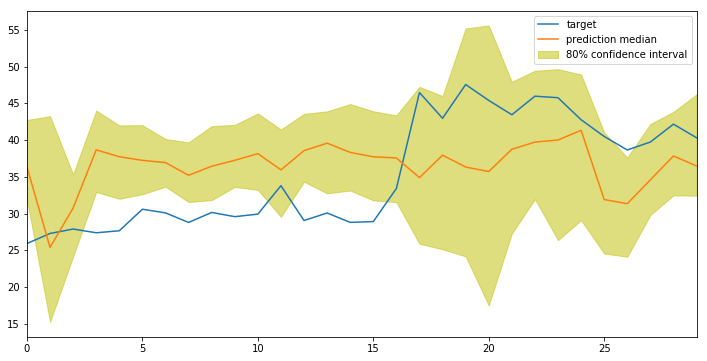

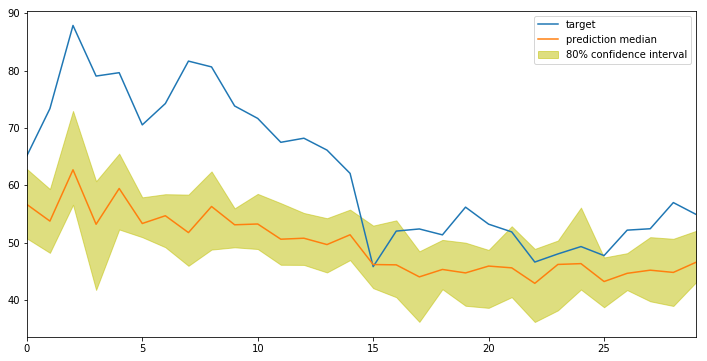

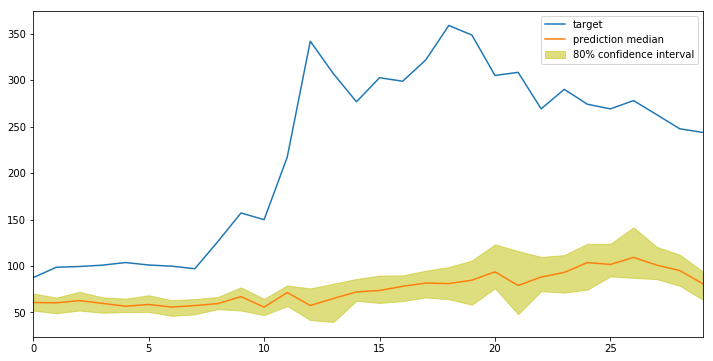

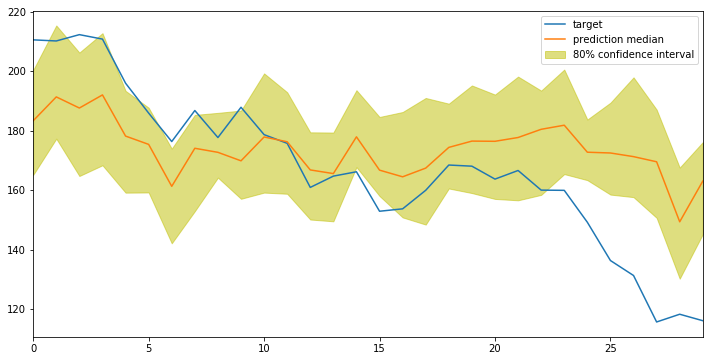

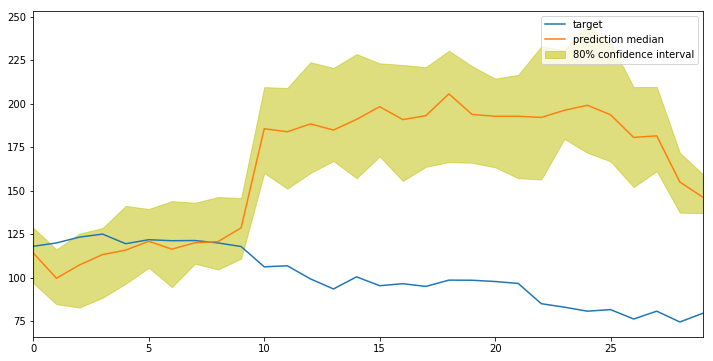

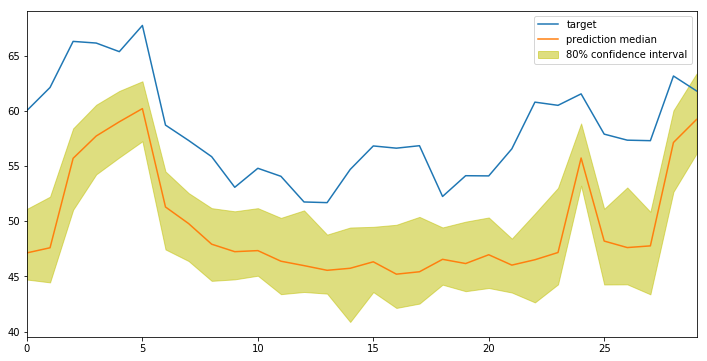

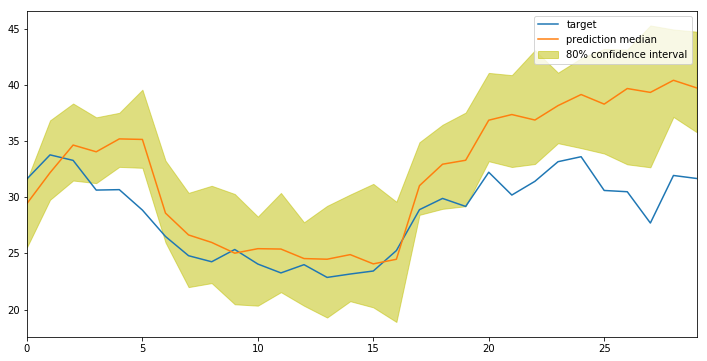

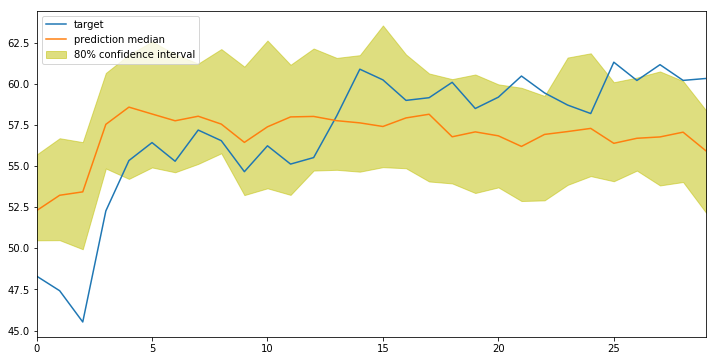

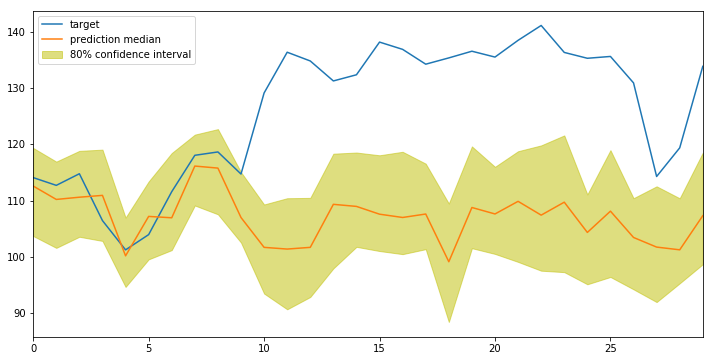

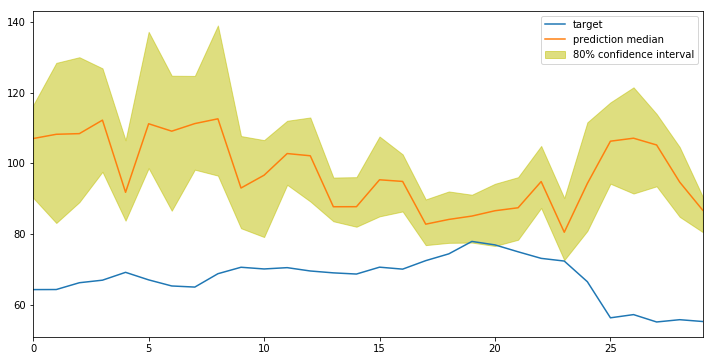

In [128]:
# display predictions
prediction_length = 30
display_quantiles(prediction_list, target_ts=quarters)

In [143]:
# Starting my prediction at the beginning of 3rd quarter 2019
start_date = '2019-09-29'
timestamp = '00:00:00'

# formatting start_date
start_time = start_date +' '+ timestamp

ts_labels = ltc_3yr.columns.values[1:]
dynamic_feat = []
    
for i in range(len(ts_labels)):
    dynamic_feat.append(list(ltc_3yr['2019-09-29':'2019-10-28'][ltc_3yr.columns.values[i]]))

# formatting request_data
# this instance has an empty target!
request_data = {"instances": [{"start": start_time, "target": [], "dynamic_feat": dynamic_feat}],
                "configuration": {"num_samples": 50,
                                  "output_types": ["quantiles"],
                                  "quantiles": ['0.1', '0.5', '0.9']}
                }

json_input = json.dumps(request_data).encode('utf-8')

print('Requesting prediction for '+start_time)

Requesting prediction for 2019-09-29 00:00:00


In [144]:
# get prediction response
json_prediction = predictor.predict(json_input)

prediction_q4 = decode_prediction(json_prediction)


In [145]:
target_q4 = ltc_3yr['2019-09-29':'2019-10-28']

In [146]:
prediction_q4

[          0.1        0.9        0.5
 0   63.017841  93.629547  80.921867
 1   78.432671  95.232956  85.206512
 2   74.936264  88.624611  81.739868
 3   74.869354  84.949333  78.946114
 4   71.910469  81.109520  76.804451
 5   70.916061  78.501083  74.741310
 6   71.905945  77.992195  76.033310
 7   71.799248  78.063454  75.501968
 8   72.254105  79.300705  75.922440
 9   72.189590  81.908958  76.694069
 10  75.264427  83.239502  78.828606
 11  73.346962  79.748001  76.798149
 12  73.389931  81.142059  76.922211
 13  74.044983  81.610336  77.824875
 14  73.674568  80.076141  76.849579
 15  75.572098  82.620193  79.011917
 16  73.987183  81.151756  76.666748
 17  72.495834  80.174721  76.422462
 18  74.541893  80.701187  77.737450
 19  73.545944  80.830055  77.669487
 20  72.132477  80.241180  76.542931
 21  73.212349  80.410439  76.869263
 22  72.793724  79.012749  75.323624
 23  73.793716  80.938271  76.602524
 24  65.565788  71.686066  69.512665
 25  71.085304  77.182724  74.560944
 

In [147]:
target_q4['Price']

date
2019-09-29    54.001144
2019-09-30    55.927208
2019-10-01    55.765906
2019-10-02    56.448218
2019-10-03    56.614479
2019-10-04    56.573141
2019-10-05    56.786484
2019-10-06    54.521839
2019-10-07    57.733823
2019-10-08    57.036728
2019-10-09    59.436602
2019-10-10    57.552446
2019-10-11    55.702243
2019-10-12    55.822620
2019-10-13    56.532920
2019-10-14    56.795286
2019-10-15    54.548698
2019-10-16    52.554284
2019-10-17    54.901029
2019-10-18    53.251189
2019-10-19    53.743133
2019-10-20    54.861684
2019-10-21    54.768957
2019-10-22    53.330875
2019-10-23    49.332035
2019-10-24    49.824631
2019-10-25    56.902924
2019-10-26    56.963597
2019-10-27    59.832752
2019-10-28    58.383654
Name: Price, dtype: float64

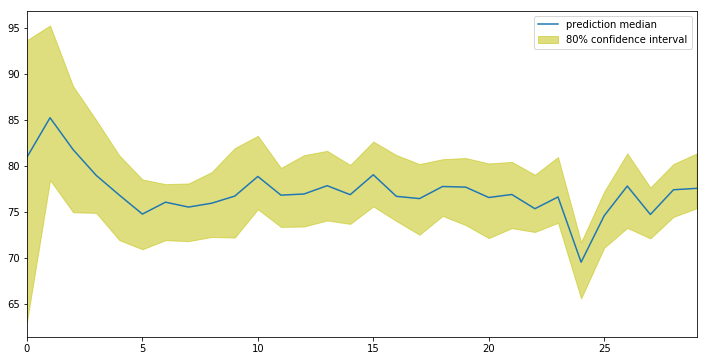

In [148]:
display_quantiles(prediction_q4)

In [40]:
def display_prediction_quantiles(prediction_list, target_ts=None):
    # show predictions for all input ts
    for k in range(len(prediction_list)):
        plt.figure(figsize=(12,6))
        # get the target month of data
        if target_ts is not None:
            target = target_ts['Price'][-30:]
            plt.plot(range(len(target)), target, label='target')
        # get the quantile values at 10 and 90%
        p10 = prediction_list[k]['0.1']
        p90 = prediction_list[k]['0.9']
        # fill the 80% confidence interval
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        # plot the median prediction line
        prediction_list[k]['0.5'].plot(label='prediction median')
        plt.legend()
        plt.show()

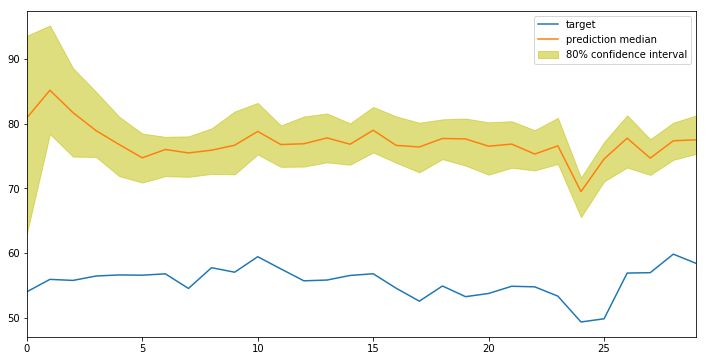

In [184]:
display_prediction_quantiles(prediction_q4, target_q4)

In [173]:
predictions = pd.DataFrame(prediction_q4[:][0])['0.5']
target = target_q4['Price']

In [41]:
def roi_display(initial_investment, predictions, actual, transaction_rate=0, buy_threshold=0,\
    sell_threshold=0):
    """Returns total return on investment through the following inputs:
    - initial_investment: initial dollar amount to be invested
    - predictions: numpy array of EOD stock price predictions from xgboost model
    - actual: numpy array of actual end of day stock prices
    - transaction_rate: rate to be charged each time transaction is made
    - buy_threshold: prediction percentage of growth before executing buying
        transaction
    - sell_threshold: prediction percentage of loss before executing selling
        transaction
    """

    investing = 0
    holding = initial_investment
    predictions = np.asarray(predictions)
    
    for i in range(len(predictions)-1):
        if holding > 0:
            if predictions[i+1]*(1-buy_threshold) > predictions[i]:
                investing = (holding*(1-transaction_rate)) / actual[i]
                print('Investing ${:.2f}'.format(holding))
                holding = 0         
        if investing > 0:
            if predictions[i+1]*(1+sell_threshold) < predictions[i]:
                holding = (investing * actual[i])*(1-transaction_rate)
                investing = 0
                print('Holding ${:.2f}'.format(holding))

    if holding > 0:
        print('Total return on investment before taxes is ${:.2f}'.format(\
        holding - initial_investment))
    else:
        print('Total return on investment before taxes is ${:.2f}'.format((\
        investing*actual[-1]) * (1-transaction_rate)-initial_investment))

In [180]:
roi_display(20000, predictions, target)

Investing $20000.00
Holding $20713.34
Investing $20713.34
Holding $20791.45
Investing $20791.45
Holding $22665.66
Investing $22665.66
Holding $21984.41
Investing $21984.41
Holding $22086.44
Investing $22086.44
Holding $23072.68
Investing $23072.68
Holding $23552.89
Investing $23552.89
Holding $22934.45
Investing $22934.45
Holding $26454.16
Investing $26454.16
Total return on investment before taxes is $7113.64


In [42]:
def get_test_loss(target, prediction):
    test_total = 0
    for i in range(len(target)):
        test_total += np.absolute(target[i] - prediction[i])
    return test_total/len(target)

In [185]:
get_test_loss(target, predictions)

21.586651202065823

In [186]:
predictor.delete_endpoint()

# Dropping some dynamic features

- BlkSizeMeanByte: because it is the calculated with BlkCnt and BlkSizeByte and therefore redundant
- CapMVRVCur: beacuase it is the ratio of CapMrktCurUSD and CapRealUSD
- FeeMedUSD: because there is also the FeeMeanUSD 
- IssContNtv: because it only includes those native units that are issued by a protocol-mandated continuous emission schedule and IssTotUSD includes all new native units issued
- NVTAdj: because NVTAdj defined as the ratio of the network value (or market capitalization, current supply) divided by the adjusted transfer value. Also referred to as NVT. This is too similar to NVTAdj90 that just moves the ratio of the network value to the 90 day average, and is still divided by the adjusted transfer value
- TxTfrValAdjNtv, TxTfrValAdjUSD: because TxTr is the sum count of transfers that day without removing anything and/or converting to USD
- TxTfrValMeanUSD: again TxTfrValMeanNtv already has this covered without converting to USD and providing more redundancy
- TxTfrValMedNtv, TxTfrValMedUSD: again trying to cut out redundancy and relying on the mean to sum up this metric.
- TxTfrValUSD, TxTfrValNtv: as the sum of native units transferred (i.e., the aggregate "size" of all transfers) that day, this metric can be inferred with the metrics TxTfr and TxTfrValMeanNtv
- VtyDayRet180d, VtyDayRet60d: more focused on short term, daily movement

In [187]:
drop_labels = ['BlkSizeMeanByte', 'CapMVRVCur', 'CapMVRVCur', 'FeeMedUSD', 'IssContNtv', 'NVTAdj', 'TxTfrValAdjNtv', \
               'TxTfrValAdjUSD', 'TxTfrValMeanUSD', 'TxTfrValMedNtv', 'TxTfrValMedUSD', 'TxTfrValUSD', 'TxTfrValNtv', \
               'VtyDayRet180d', 'VtyDayRet60d']

In [188]:
ltc_3yr = ltc_3yr.drop(labels=drop_labels, axis=1)

In [189]:
ltc_3yr.head()

,Price,AdrActCnt,BlkCnt,BlkSizeByte,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,FeeMeanUSD,FeeMedNtv,...,IssTotNtv,IssTotUSD,NVTAdj90,ROI1yr,ROI30d,SplyCur,TxCnt,TxTfrCnt,TxTfrValMeanNtv,VtyDayRet30d
date,,,,,,,,,,,,,,,,,,,,,
2017-04-01,7.603259,31607,602,4702263,3.835566e+08,3.141564e+08,87460.092017,0.003258,0.024771,0.001,...,15050.0,114429.053725,77.245634,133.689376,87.864131,5.044633e+07,5447,32848,176.263868,0.106791
2017-04-02,8.321471,26028,593,5353315,4.199110e+08,3.174778e+08,87420.907407,0.002861,0.023805,0.001,...,14825.0,123365.801858,84.407247,154.902041,103.671935,5.046116e+07,7533,22124,368.518821,0.107506
2017-04-03,8.516944,19696,635,5222384,4.299101e+08,3.203666e+08,87420.907407,0.002921,0.024876,0.001,...,15875.0,135206.483442,83.896562,161.504096,113.183716,5.047703e+07,7580,20878,356.530024,0.107153
2017-04-04,9.138647,16274,654,4732539,4.614412e+08,3.302066e+08,91264.147893,0.002666,0.024360,0.001,...,16350.0,149416.872208,85.308629,182.265210,128.582280,5.049338e+07,6781,17362,557.767370,0.107359
2017-04-05,12.370317,24797,598,6757351,6.248041e+08,3.538675e+08,92957.205376,0.003474,0.042969,0.001,...,14950.0,184936.238750,107.247986,280.283584,201.720856,5.050833e+07,9709,28295,693.664944,0.118530


In [190]:
time_series = []

start_idx = 0

for i in q:
    end_idx = start_idx + q[i] + 1
    
    data = ltc_3yr[:][start_idx:end_idx]

    time_series.append(pd.DataFrame(data=data))
    
    start_idx = end_idx

In [191]:
q2_2017 = pd.DataFrame(time_series[0])
q3_2017 = pd.DataFrame(time_series[1])
q4_2017 = pd.DataFrame(time_series[2])
q1_2018 = pd.DataFrame(time_series[3])
q2_2018 = pd.DataFrame(time_series[4])
q3_2018 = pd.DataFrame(time_series[5])
q4_2018 = pd.DataFrame(time_series[6])
q1_2019 = pd.DataFrame(time_series[7])
q2_2019 = pd.DataFrame(time_series[8])
q3_2019 = pd.DataFrame(time_series[9])

In [192]:
quarters = [q2_2017,q3_2017,q4_2017,q1_2018,q2_2018,q3_2018,q4_2018,q1_2019,q2_2019,q3_2019]

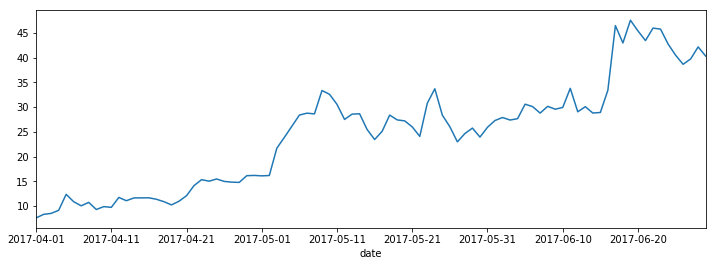

In [193]:
plt.figure(figsize=(12,4))
quarters[0]['Price'].plot()
plt.show()

In [194]:
q2_2017_train = pd.DataFrame(time_series[0][:-30])
q3_2017_train = pd.DataFrame(time_series[1][:-30])
q4_2017_train = pd.DataFrame(time_series[2][:-30])
q1_2018_train = pd.DataFrame(time_series[3][:-30])
q2_2018_train = pd.DataFrame(time_series[4][:-30])
q3_2018_train = pd.DataFrame(time_series[5][:-30])
q4_2018_train = pd.DataFrame(time_series[6][:-30])
q1_2019_train = pd.DataFrame(time_series[7][:-30])
q2_2019_train = pd.DataFrame(time_series[8][:-30])
q3_2019_train = pd.DataFrame(time_series[9][:-30])

In [195]:
quarters_training = [q2_2017_train,q3_2017_train,q4_2017_train,q1_2018_train,q2_2018_train,q3_2018_train,
                     q4_2018_train,q1_2019_train,q2_2019_train,q3_2019_train]

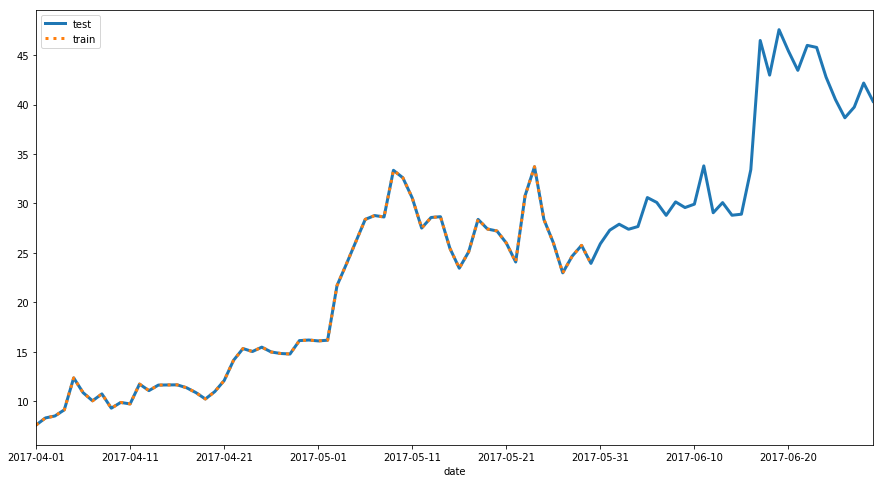

In [24]:
plt.figure(figsize=(15,8))
# test data is the whole time series
quarters[0]['Price'].plot(label='test', lw=3)
# train data is all but the last prediction pts
quarters_training[0]['Price'].plot(label='train', ls=':', lw=3)
plt.xticks(np.arange(90, step=10), xlabels)
plt.legend()
plt.show()

In [197]:
series_to_json_obj(quarters[1])

{'start': '2017-06-30',
 'target': [39.369128254076706,
  38.1163571232574,
  41.617455616226394,
  45.708711580536395,
  54.4523606456279,
  53.248043504381,
  51.40006913638761,
  46.350343786792294,
  51.6587449913222,
  48.754163593537704,
  44.0230875686742,
  44.0946844839085,
  46.731747807854795,
  45.504595819607,
  42.614295927143104,
  38.5651422356585,
  40.7532560471325,
  42.3545210340915,
  43.5155672829493,
  39.970670489419796,
  44.5346130283284,
  45.3900137120577,
  46.995724018766005,
  45.1371263690174,
  44.889682047008705,
  42.008072583693206,
  41.9145169899964,
  41.7955063748825,
  40.0706591216819,
  40.980801656283795,
  40.288620206751496,
  42.245006213968296,
  43.1233744223086,
  41.571807092631005,
  42.550513470047996,
  43.10718762375279,
  45.9521064955457,
  45.3380507828088,
  45.90246267723829,
  49.1797753796553,
  47.65650380781221,
  47.3241376146049,
  47.0106506441056,
  46.2759343627748,
  45.146257144645396,
  45.517545259356396,
  43.105

In [198]:
# save this data to a local directory
data_dir = 'deep_ar_quarters_reduced'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [199]:
# directories to save train/test data
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

# write train/test JSON files
write_json_dataset(quarters_training, train_key)        
write_json_dataset(quarters, test_key)

deep_ar_quarters_reduced/train.json saved.
deep_ar_quarters_reduced/test.json saved.


## Uploading Data to S3

Next, to make this data accessible to an estimator, I'll upload it to S3.


In [200]:
# general prefix
prefix='deepar-ltc'

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)

In [201]:
# check locations
print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-us-east-1-561941966718/deepar-ltc/train/train.json
Test data is stored in: s3://sagemaker-us-east-1-561941966718/deepar-ltc/test/test.json


# Training a DeepAR Estimator

Some estimators have specific, SageMaker constructors, but not all. Instead you can create a base `Estimator` and pass in the specific image (or container) that holds a specific model.

Next, we configure the container image to be used for the region that we are running in.

In [202]:
image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image


In [203]:
# dir to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

# instantiate a DeepAR estimator
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

In [204]:
freq='D'
context_length=30 # same as prediction_length

hyperparameters = {
    "epochs": "50",
    "time_freq": freq,
    "prediction_length": str(30),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

In [205]:
# set the hyperparams
estimator.set_hyperparameters(**hyperparameters)

In [206]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

2019-12-20 17:03:44 Starting - Starting the training job...
2019-12-20 17:03:45 Starting - Launching requested ML instances......
2019-12-20 17:04:51 Starting - Preparing the instances for training...
2019-12-20 17:05:43 Downloading - Downloading input data......
2019-12-20 17:06:41 Training - Training image download completed. Training in progress..Arguments: train
[12/20/2019 17:06:44 INFO 140686173435712] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience':

[12/20/2019 17:06:51 INFO 140686173435712] Epoch[2] Batch[10] avg_epoch_loss=3.531465
[12/20/2019 17:06:51 INFO 140686173435712] #quality_metric: host=algo-1, epoch=2, batch=10 train loss <loss>=3.40195646286
[12/20/2019 17:06:51 INFO 140686173435712] Epoch[2] Batch [10]#011Speed: 726.55 samples/sec#011loss=3.401956
[12/20/2019 17:06:51 INFO 140686173435712] processed a total of 1318 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2142.817974090576, "sum": 2142.817974090576, "min": 2142.817974090576}}, "EndTime": 1576861611.523717, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1576861609.380822}

[12/20/2019 17:06:51 INFO 140686173435712] #throughput_metric: host=algo-1, train throughput=615.040545713 records/second
[12/20/2019 17:06:51 INFO 140686173435712] #progress_metric: host=algo-1, completed 6 % of epochs
[12/20/2019 17:06:51 INFO 140686173435712] #quality_metric: host=algo-1, epoch=2, train loss <loss>=3.531

[12/20/2019 17:07:01 INFO 140686173435712] Epoch[7] Batch[5] avg_epoch_loss=3.005844
[12/20/2019 17:07:01 INFO 140686173435712] #quality_metric: host=algo-1, epoch=7, batch=5 train loss <loss>=3.00584447384
[12/20/2019 17:07:01 INFO 140686173435712] Epoch[7] Batch [5]#011Speed: 732.60 samples/sec#011loss=3.005844
[12/20/2019 17:07:02 INFO 140686173435712] Epoch[7] Batch[10] avg_epoch_loss=3.030131
[12/20/2019 17:07:02 INFO 140686173435712] #quality_metric: host=algo-1, epoch=7, batch=10 train loss <loss>=3.05927524567
[12/20/2019 17:07:02 INFO 140686173435712] Epoch[7] Batch [10]#011Speed: 703.21 samples/sec#011loss=3.059275
[12/20/2019 17:07:02 INFO 140686173435712] processed a total of 1332 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2201.185941696167, "sum": 2201.185941696167, "min": 2201.185941696167}}, "EndTime": 1576861622.534257, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1576861620.332512}

[12/20/201

[12/20/2019 17:07:20 INFO 140686173435712] Epoch[16] Batch[5] avg_epoch_loss=2.632088
[12/20/2019 17:07:20 INFO 140686173435712] #quality_metric: host=algo-1, epoch=16, batch=5 train loss <loss>=2.63208822409
[12/20/2019 17:07:20 INFO 140686173435712] Epoch[16] Batch [5]#011Speed: 741.77 samples/sec#011loss=2.632088
[12/20/2019 17:07:21 INFO 140686173435712] processed a total of 1279 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1946.152925491333, "sum": 1946.152925491333, "min": 1946.152925491333}}, "EndTime": 1576861641.522846, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1576861639.576624}

[12/20/2019 17:07:21 INFO 140686173435712] #throughput_metric: host=algo-1, train throughput=657.146408067 records/second
[12/20/2019 17:07:21 INFO 140686173435712] #progress_metric: host=algo-1, completed 34 % of epochs
[12/20/2019 17:07:21 INFO 140686173435712] #quality_metric: host=algo-1, epoch=16, train loss <loss>=2.6

[12/20/2019 17:07:31 INFO 140686173435712] Epoch[21] Batch[5] avg_epoch_loss=2.460004
[12/20/2019 17:07:31 INFO 140686173435712] #quality_metric: host=algo-1, epoch=21, batch=5 train loss <loss>=2.46000381311
[12/20/2019 17:07:31 INFO 140686173435712] Epoch[21] Batch [5]#011Speed: 738.32 samples/sec#011loss=2.460004
[12/20/2019 17:07:31 INFO 140686173435712] processed a total of 1279 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1960.5579376220703, "sum": 1960.5579376220703, "min": 1960.5579376220703}}, "EndTime": 1576861651.918813, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1576861649.95814}

[12/20/2019 17:07:31 INFO 140686173435712] #throughput_metric: host=algo-1, train throughput=652.312406256 records/second
[12/20/2019 17:07:31 INFO 140686173435712] #progress_metric: host=algo-1, completed 44 % of epochs
[12/20/2019 17:07:31 INFO 140686173435712] #quality_metric: host=algo-1, epoch=21, train loss <loss>=2

[12/20/2019 17:07:41 INFO 140686173435712] Epoch[26] Batch[5] avg_epoch_loss=2.476210
[12/20/2019 17:07:41 INFO 140686173435712] #quality_metric: host=algo-1, epoch=26, batch=5 train loss <loss>=2.47620987892
[12/20/2019 17:07:41 INFO 140686173435712] Epoch[26] Batch [5]#011Speed: 739.67 samples/sec#011loss=2.476210
[12/20/2019 17:07:42 INFO 140686173435712] processed a total of 1253 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1949.2290019989014, "sum": 1949.2290019989014, "min": 1949.2290019989014}}, "EndTime": 1576861662.133211, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1576861660.183589}

[12/20/2019 17:07:42 INFO 140686173435712] #throughput_metric: host=algo-1, train throughput=642.775335501 records/second
[12/20/2019 17:07:42 INFO 140686173435712] #progress_metric: host=algo-1, completed 54 % of epochs
[12/20/2019 17:07:42 INFO 140686173435712] #quality_metric: host=algo-1, epoch=26, train loss <loss>=


2019-12-20 17:08:13 Uploading - Uploading generated training model[12/20/2019 17:08:01 INFO 140686173435712] Epoch[36] Batch[0] avg_epoch_loss=2.416384
[12/20/2019 17:08:01 INFO 140686173435712] #quality_metric: host=algo-1, epoch=36, batch=0 train loss <loss>=2.41638445854
[12/20/2019 17:08:02 INFO 140686173435712] Epoch[36] Batch[5] avg_epoch_loss=2.381077
[12/20/2019 17:08:02 INFO 140686173435712] #quality_metric: host=algo-1, epoch=36, batch=5 train loss <loss>=2.38107740879
[12/20/2019 17:08:02 INFO 140686173435712] Epoch[36] Batch [5]#011Speed: 717.69 samples/sec#011loss=2.381077
[12/20/2019 17:08:02 INFO 140686173435712] processed a total of 1272 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2009.3610286712646, "sum": 2009.3610286712646, "min": 2009.3610286712646}}, "EndTime": 1576861682.845601, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1576861680.835738}

[12/20/2019 17:08:02 INFO 140686173435712] #th

In [207]:
%%time

# create a predictor
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    content_type="application/json" # specify that it will accept/produce JSON
)

---------------------------------------------------------------------------------------------------------------------------------------!CPU times: user 667 ms, sys: 59.8 ms, total: 727 ms
Wall time: 11min 22s


In [208]:
# get all input and target (test) time series
input_ts = quarters_training
target_ts = quarters

# get formatted input time series
json_input_ts = json_predictor_input(input_ts, target_ts)

# get the prediction from the predictor
json_prediction = predictor.predict(json_input_ts)


In [209]:
print(json_prediction)

b'{"predictions":[{"quantiles":{"0.1":[23.6106376648,21.4647293091,23.3482265472,18.3820400238,19.6836986542,17.676027298,20.9138832092,21.0763053894,24.6063270569,22.6526355743,14.5932788849,15.7483196259,22.2290916443,19.1840057373,22.3998298645,14.1632881165,24.5259609222,9.6117744446,14.3217029572,20.3269042969,22.4404373169,24.7603282928,21.5876312256,7.2255897522,8.4958438873,22.7325325012,22.1557426453,18.1585121155,17.2743759155,23.5499973297],"0.9":[51.5126800537,45.5628738403,48.0066719055,44.9577293396,56.4377593994,48.2291717529,49.3954544067,47.0836791992,51.6096191406,56.0353736877,51.4879264832,50.8043365479,50.8408737183,47.6763038635,54.5460510254,46.4808921814,45.6802635193,57.7533073425,59.8656806946,59.0423164368,53.6538581848,52.8266868591,50.5399017334,51.4938240051,48.1646652222,47.096408844,50.891620636,51.167098999,47.8625183105,49.0209350586],"0.5":[37.9234161377,34.6156234741,34.5801239014,34.0686912537,34.4356498718,33.2196388245,35.5604629517,35.4058990479,

In [210]:
# get quantiles/predictions
prediction_list = decode_prediction(json_prediction)

# should get a list of 30 predictions 
# with corresponding quantile values
print(prediction_list[1])

          0.1        0.9        0.5
0   35.045403  54.272594  43.237770
1   34.385799  51.975216  43.538769
2   33.508522  52.073685  43.654926
3   34.928238  53.031044  42.412586
4   36.204556  51.455521  43.057709
5   37.680996  53.081696  44.458096
6   33.487591  49.314968  42.196335
7   34.584923  49.695873  42.635143
8   36.012169  50.012817  43.873188
9   35.600929  51.133095  44.339714
10  36.551670  52.341431  44.556717
11  35.836628  52.254616  42.948051
12  35.672546  55.831318  43.196556
13  38.175793  57.020187  43.863800
14  36.143131  51.204762  42.796761
15  26.875675  39.517521  33.801067
16  29.639160  48.165691  38.549183
17  32.482807  48.510773  39.852680
18  32.144421  45.544037  37.023029
19  31.528976  42.486858  35.970634
20  32.766346  41.782135  36.028198
21  31.828911  45.091175  37.511101
22  21.764595  36.441074  29.823250
23  30.947964  50.641975  37.142693
24  29.760092  41.334480  35.076294
25  27.332462  47.562801  36.872841
26  31.321712  42.094841  36

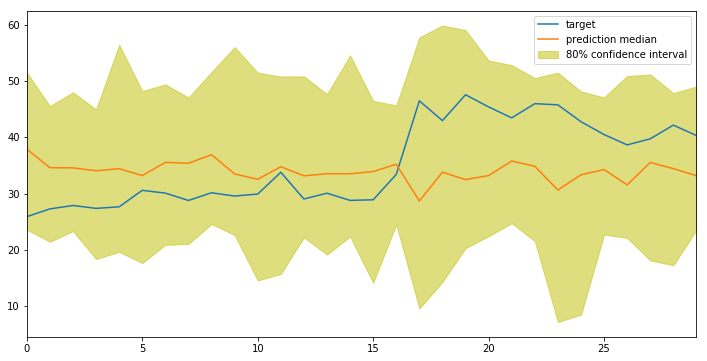

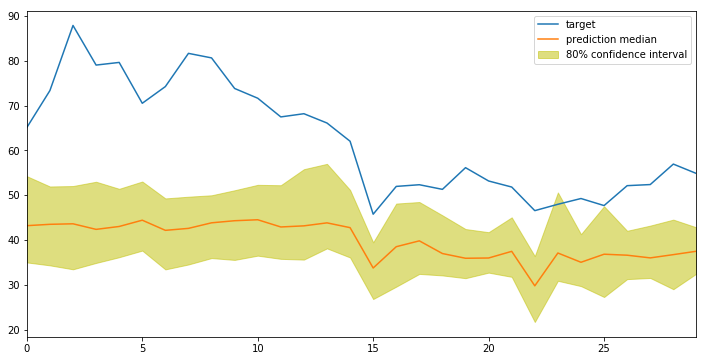

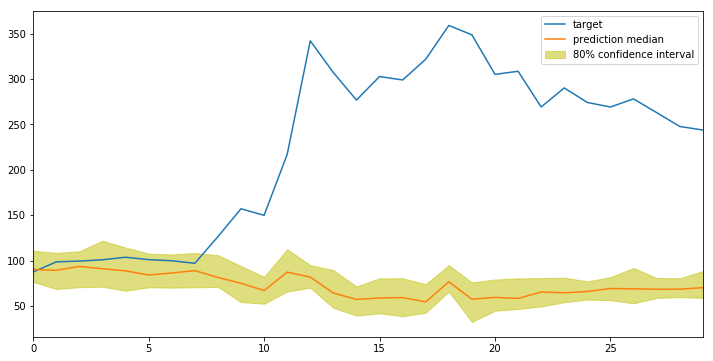

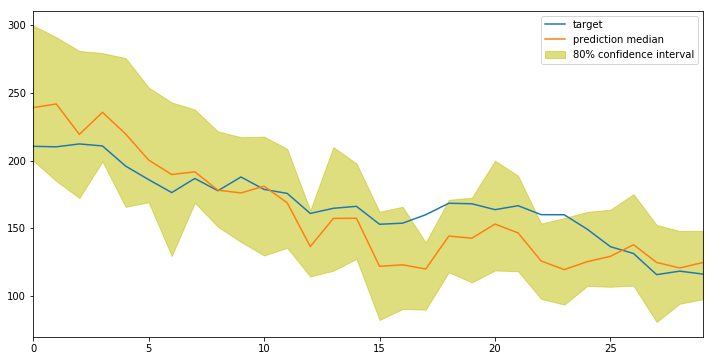

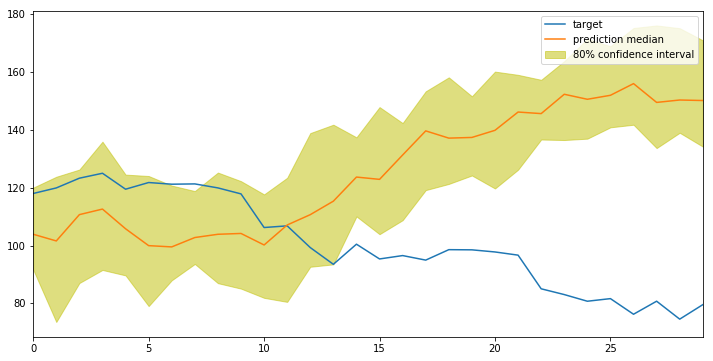

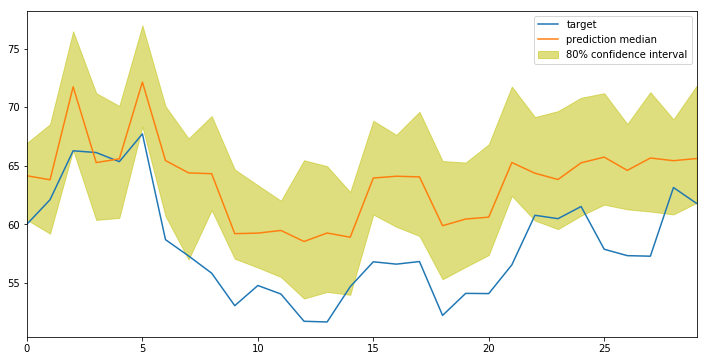

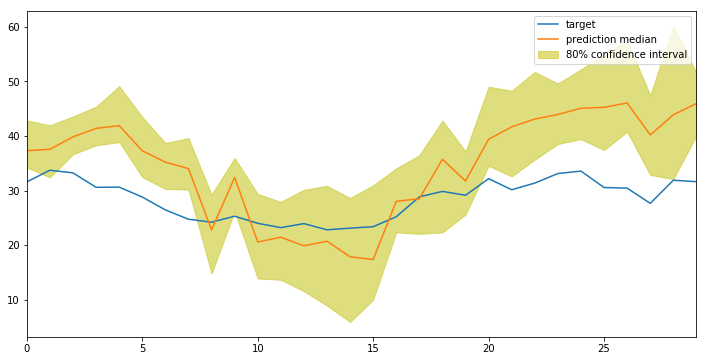

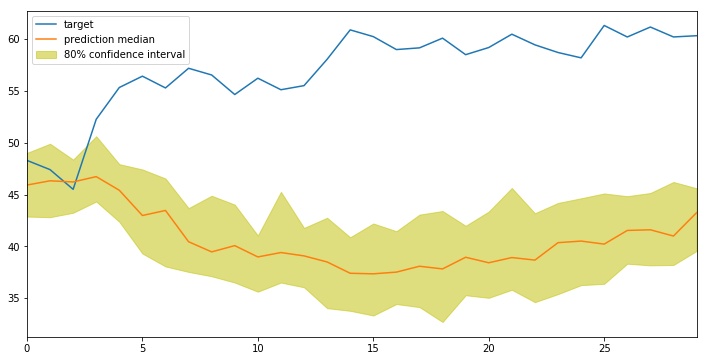

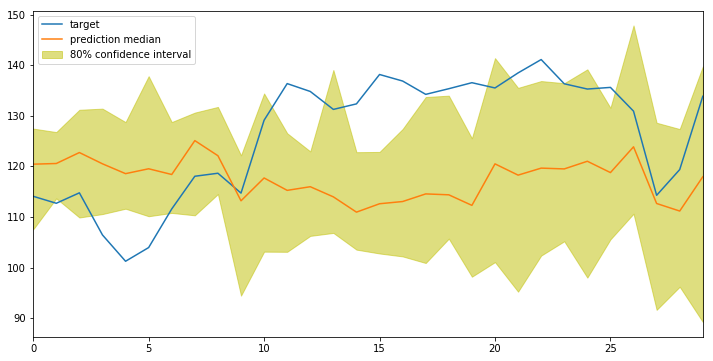

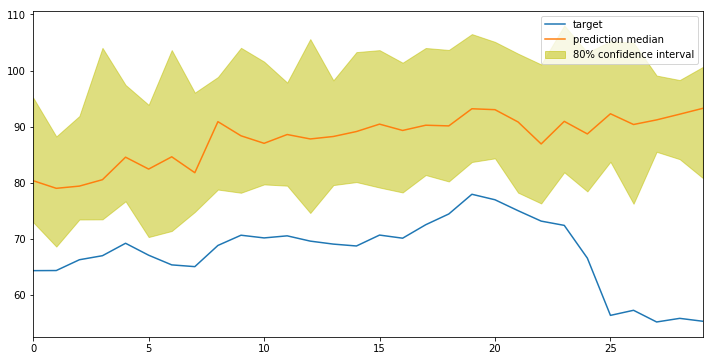

In [217]:
# display predictions
display_quantiles(prediction_list, target_ts=quarters)

In [218]:
# Starting my prediction at the beginning of 3rd quarter 2019
start_date = '2019-09-29'
timestamp = '00:00:00'

# formatting start_date
start_time = start_date +' '+ timestamp

ts_labels = ltc_3yr.columns.values[1:]
dynamic_feat = []
    
for i in range(len(ts_labels)):
    dynamic_feat.append(list(ltc_3yr['2019-09-29':'2019-10-29'][ltc_3yr.columns.values[i]]))

# formatting request_data
# this instance has an empty target!
request_data = {"instances": [{"start": start_time, "target": [], "dynamic_feat": dynamic_feat}],
                "configuration": {"num_samples": 50,
                                  "output_types": ["quantiles"],
                                  "quantiles": ['0.1', '0.5', '0.9']}
                }

json_input = json.dumps(request_data).encode('utf-8')

print('Requesting prediction for '+start_time)

Requesting prediction for 2019-09-29 00:00:00


In [219]:
# get prediction response
json_prediction = predictor.predict(json_input)

prediction_q4 = decode_prediction(json_prediction)


In [220]:
target_q4 = ltc_3yr['2019-09-29':'2019-10-28']

In [221]:
target_q4['Price']

date
2019-09-29    54.001144
2019-09-30    55.927208
2019-10-01    55.765906
2019-10-02    56.448218
2019-10-03    56.614479
2019-10-04    56.573141
2019-10-05    56.786484
2019-10-06    54.521839
2019-10-07    57.733823
2019-10-08    57.036728
2019-10-09    59.436602
2019-10-10    57.552446
2019-10-11    55.702243
2019-10-12    55.822620
2019-10-13    56.532920
2019-10-14    56.795286
2019-10-15    54.548698
2019-10-16    52.554284
2019-10-17    54.901029
2019-10-18    53.251189
2019-10-19    53.743133
2019-10-20    54.861684
2019-10-21    54.768957
2019-10-22    53.330875
2019-10-23    49.332035
2019-10-24    49.824631
2019-10-25    56.902924
2019-10-26    56.963597
2019-10-27    59.832752
2019-10-28    58.383654
Name: Price, dtype: float64

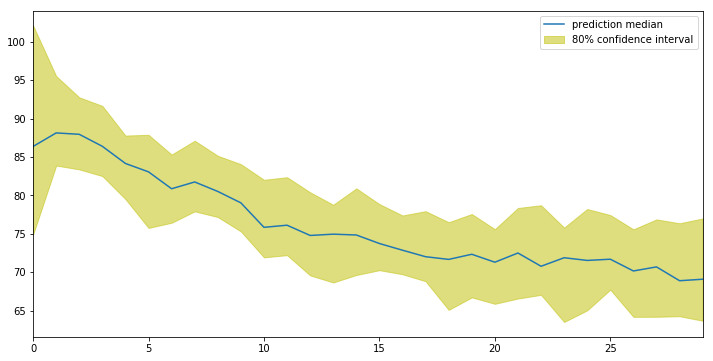

In [222]:
display_quantiles(prediction_q4)

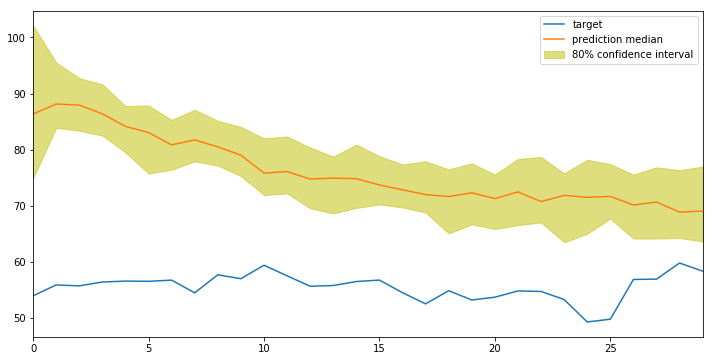

In [223]:
display_prediction_quantiles(prediction_q4, target_q4)

In [224]:
predictions = pd.DataFrame(prediction_q4[:][0])['0.5']
target = target_q4['Price']

In [233]:
roi_display(20000, predictions, target)

Investing $20000.00
Holding $20713.34
Investing $20713.34
Holding $19887.29
Investing $19887.29
Holding $19256.86
Investing $19256.86
Holding $19298.48
Investing $19298.48
Holding $18718.54
Investing $18718.54
Holding $19108.12
Investing $19108.12
Holding $18606.40
Investing $18606.40
Holding $18792.19
Investing $18792.19
Holding $18812.22
Investing $18812.22
Total return on investment before taxes is $-1643.39


In [234]:
get_test_loss(target, predictions)

20.654544929692488

In [235]:
predictor.delete_endpoint()

# With no dynamic features

In [24]:
def series_to_json_obj_no_dynamicfeats(ts):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    
    # get start time and target from the time series, ts
    json_obj = {"start": str(ts.index[0]), "target": list(ts['Price'])}
    return json_obj

In [25]:
series_to_json_obj_no_dynamicfeats(quarters[1])

{'start': '2017-06-30',
 'target': [39.369128254076706,
  38.1163571232574,
  41.617455616226394,
  45.708711580536395,
  54.4523606456279,
  53.248043504381,
  51.40006913638761,
  46.350343786792294,
  51.6587449913222,
  48.754163593537704,
  44.0230875686742,
  44.0946844839085,
  46.731747807854795,
  45.504595819607,
  42.614295927143104,
  38.5651422356585,
  40.7532560471325,
  42.3545210340915,
  43.5155672829493,
  39.970670489419796,
  44.5346130283284,
  45.3900137120577,
  46.995724018766005,
  45.1371263690174,
  44.889682047008705,
  42.008072583693206,
  41.9145169899964,
  41.7955063748825,
  40.0706591216819,
  40.980801656283795,
  40.288620206751496,
  42.245006213968296,
  43.1233744223086,
  41.571807092631005,
  42.550513470047996,
  43.10718762375279,
  45.9521064955457,
  45.3380507828088,
  45.90246267723829,
  49.1797753796553,
  47.65650380781221,
  47.3241376146049,
  47.0106506441056,
  46.2759343627748,
  45.146257144645396,
  45.517545259356396,
  43.105

In [26]:
# save this data to a local directory
data_dir = 'deep_ar_quarters_no_dynamicfeats'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [27]:
# directories to save train/test data
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

# write train/test JSON files
write_json_dataset(quarters_training, train_key)        
write_json_dataset(quarters, test_key)

deep_ar_quarters_no_dynamicfeats/train.json saved.
deep_ar_quarters_no_dynamicfeats/test.json saved.


## Uploading Data to S3

Next, to make this data accessible to an estimator, I'll upload it to S3.


In [28]:
# general prefix
prefix='deepar-ltc'

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)

In [29]:
# check locations
print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-us-east-1-561941966718/deepar-ltc/train/train.json
Test data is stored in: s3://sagemaker-us-east-1-561941966718/deepar-ltc/test/test.json


# Training a DeepAR Estimator

Some estimators have specific, SageMaker constructors, but not all. Instead you can create a base `Estimator` and pass in the specific image (or container) that holds a specific model.

Next, we configure the container image to be used for the region that we are running in.

In [30]:
image_name = get_image_uri(boto3.Session().region_name, # get the region
                           'forecasting-deepar') # specify image


In [31]:
# dir to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

# instantiate a DeepAR estimator
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=image_name,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

In [32]:
freq='D'
context_length=30 # same as prediction_length

hyperparameters = {
    "epochs": "50",
    "time_freq": freq,
    "prediction_length": str(30),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

In [33]:
# set the hyperparams
estimator.set_hyperparameters(**hyperparameters)

In [34]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

2020-01-03 22:05:15 Starting - Starting the training job...
2020-01-03 22:05:17 Starting - Launching requested ML instances.........
2020-01-03 22:06:47 Starting - Preparing the instances for training......
2020-01-03 22:08:05 Downloading - Downloading input data...
2020-01-03 22:08:31 Training - Downloading the training image..Arguments: train
[01/03/2020 22:08:53 INFO 139628292581184] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[01/03/2020 22:0


2020-01-03 22:08:50 Training - Training image download completed. Training in progress.[01/03/2020 22:09:02 INFO 139628292581184] Epoch[3] Batch[5] avg_epoch_loss=3.165575
[01/03/2020 22:09:02 INFO 139628292581184] #quality_metric: host=algo-1, epoch=3, batch=5 train loss <loss>=3.1655746301
[01/03/2020 22:09:02 INFO 139628292581184] Epoch[3] Batch [5]#011Speed: 726.71 samples/sec#011loss=3.165575
[01/03/2020 22:09:03 INFO 139628292581184] processed a total of 1280 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2004.6930313110352, "sum": 2004.6930313110352, "min": 2004.6930313110352}}, "EndTime": 1578089343.068182, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578089341.063424}

[01/03/2020 22:09:03 INFO 139628292581184] #throughput_metric: host=algo-1, train throughput=638.467044265 records/second
[01/03/2020 22:09:03 INFO 139628292581184] #progress_metric: host=algo-1, completed 8 % of epochs
[01/03/2020 22:09:

[01/03/2020 22:09:12 INFO 139628292581184] Epoch[8] Batch[0] avg_epoch_loss=2.686274
[01/03/2020 22:09:12 INFO 139628292581184] #quality_metric: host=algo-1, epoch=8, batch=0 train loss <loss>=2.68627429008
[01/03/2020 22:09:12 INFO 139628292581184] Epoch[8] Batch[5] avg_epoch_loss=2.696602
[01/03/2020 22:09:12 INFO 139628292581184] #quality_metric: host=algo-1, epoch=8, batch=5 train loss <loss>=2.69660198689
[01/03/2020 22:09:12 INFO 139628292581184] Epoch[8] Batch [5]#011Speed: 743.32 samples/sec#011loss=2.696602
[01/03/2020 22:09:13 INFO 139628292581184] processed a total of 1280 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1986.098051071167, "sum": 1986.098051071167, "min": 1986.098051071167}}, "EndTime": 1578089353.614614, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578089351.628452}

[01/03/2020 22:09:13 INFO 139628292581184] #throughput_metric: host=algo-1, train throughput=644.444098738 records/second

[01/03/2020 22:09:32 INFO 139628292581184] Epoch[17] Batch[10] avg_epoch_loss=2.440056
[01/03/2020 22:09:32 INFO 139628292581184] #quality_metric: host=algo-1, epoch=17, batch=10 train loss <loss>=2.4510802269
[01/03/2020 22:09:32 INFO 139628292581184] Epoch[17] Batch [10]#011Speed: 738.68 samples/sec#011loss=2.451080
[01/03/2020 22:09:32 INFO 139628292581184] processed a total of 1312 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2241.4190769195557, "sum": 2241.4190769195557, "min": 2241.4190769195557}}, "EndTime": 1578089372.541119, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578089370.299223}

[01/03/2020 22:09:32 INFO 139628292581184] #throughput_metric: host=algo-1, train throughput=585.30847145 records/second
[01/03/2020 22:09:32 INFO 139628292581184] #progress_metric: host=algo-1, completed 36 % of epochs
[01/03/2020 22:09:32 INFO 139628292581184] #quality_metric: host=algo-1, epoch=17, train loss <loss>

[01/03/2020 22:09:52 INFO 139628292581184] Epoch[27] Batch[5] avg_epoch_loss=2.366340
[01/03/2020 22:09:52 INFO 139628292581184] #quality_metric: host=algo-1, epoch=27, batch=5 train loss <loss>=2.36633952459
[01/03/2020 22:09:52 INFO 139628292581184] Epoch[27] Batch [5]#011Speed: 751.25 samples/sec#011loss=2.366340
[01/03/2020 22:09:53 INFO 139628292581184] processed a total of 1277 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 2041.4140224456787, "sum": 2041.4140224456787, "min": 2041.4140224456787}}, "EndTime": 1578089393.331745, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1578089391.289922}

[01/03/2020 22:09:53 INFO 139628292581184] #throughput_metric: host=algo-1, train throughput=625.50909974 records/second
[01/03/2020 22:09:53 INFO 139628292581184] #progress_metric: host=algo-1, completed 56 % of epochs
[01/03/2020 22:09:53 INFO 139628292581184] #quality_metric: host=algo-1, epoch=27, train loss <loss>=2

Training seconds: 133
Billable seconds: 133
CPU times: user 695 ms, sys: 25.2 ms, total: 720 ms
Wall time: 5min 13s


In [35]:
%%time

# create a predictor
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    content_type="application/json" # specify that it will accept/produce JSON
)

---------------------------------------------------------------------------------------------------------------------------------------------------------------!CPU times: user 803 ms, sys: 30.6 ms, total: 834 ms
Wall time: 13min 23s


In [45]:
# get all input and target (test) time series
input_ts = quarters_training
target_ts = quarters

# get formatted input time series
json_input_ts = json_predictor_input(input_ts, target_ts)

# get the prediction from the predictor
json_prediction = predictor.predict(json_input_ts)


In [46]:
print(json_prediction)

b'{"predictions":[{"quantiles":{"0.1":[29.8982543945,15.3058004379,24.2378768921,31.9832210541,31.3318061829,31.8026943207,32.6288452148,30.3359622955,30.6521568298,32.3546218872,32.4294586182,28.6019649506,33.0386505127,31.6332054138,31.5263442993,29.9980125427,29.7252750397,27.5908737183,25.8504581451,27.1861457825,21.7411651611,29.1089057922,30.2515659332,30.9349784851,32.7741279602,22.8918476105,26.5317687988,27.4330024719,30.7572250366,30.4530487061],"0.9":[40.170791626,40.9883842468,34.6647796631,42.2432594299,40.4094619751,40.6944351196,38.8815307617,38.0117721558,40.2291564941,39.9959106445,42.2218437195,39.8590011597,41.6095809937,42.1084861755,42.6194572449,41.3218154907,40.5466461182,45.3847312927,42.5850334167,50.7611351013,49.9154891968,41.3556137085,46.1194076538,44.4602890015,44.8498916626,35.2709884644,35.9742584229,38.9018287659,40.5859298706,42.4946937561],"0.5":[34.2164993286,24.6471309662,30.3749694824,37.3113250732,36.5169296265,36.0775794983,35.8030433655,33.81910

In [47]:
# get quantiles/predictions
prediction_list = decode_prediction(json_prediction)

# should get a list of 30 predictions 
# with corresponding quantile values
print(prediction_list[1])

          0.1        0.9        0.5
0   51.525524  62.071083  56.663479
1   47.546280  58.915962  54.637775
2   55.330204  71.662262  64.189957
3   48.494545  62.627998  53.716667
4   52.706551  66.279854  60.049706
5   50.296112  59.479900  54.230389
6   50.263481  60.851788  55.686951
7   46.450069  58.063843  52.427086
8   52.712948  64.144287  56.695240
9   47.360817  58.250744  53.655441
10  49.357754  58.261219  53.443085
11  45.635639  57.085541  51.296608
12  43.804607  54.378162  51.062744
13  44.434380  52.004055  48.659744
14  48.195995  56.051060  51.526348
15  42.727303  49.453403  45.556168
16  40.070290  52.735863  45.602482
17  37.362156  47.498730  41.417267
18  39.333660  46.236526  43.112530
19  39.714931  45.884037  42.110298
20  39.606750  47.192017  43.788620
21  37.890152  46.976486  42.455650
22  36.197189  44.872688  41.356548
23  40.026890  45.791885  43.009972
24  40.130390  47.660084  44.729515
25  37.475471  44.050209  41.638077
26  38.767715  46.400688  42

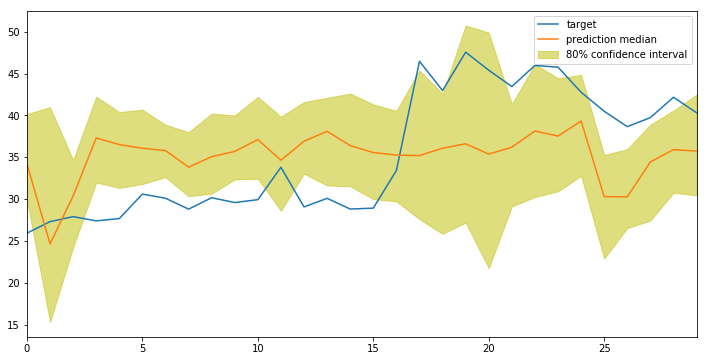

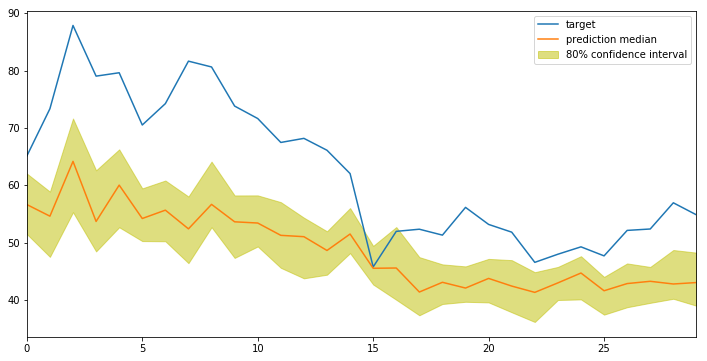

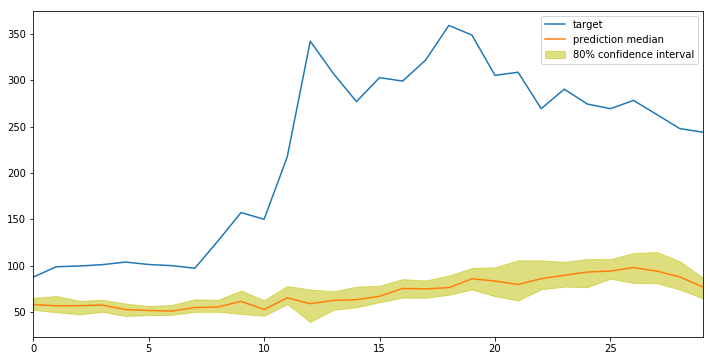

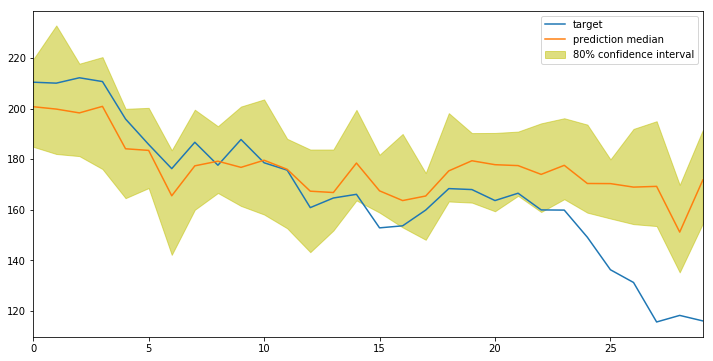

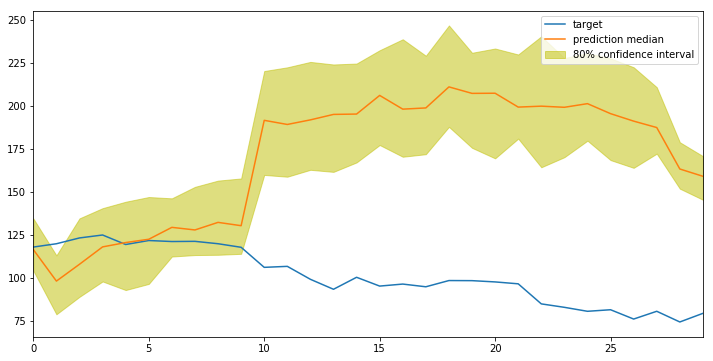

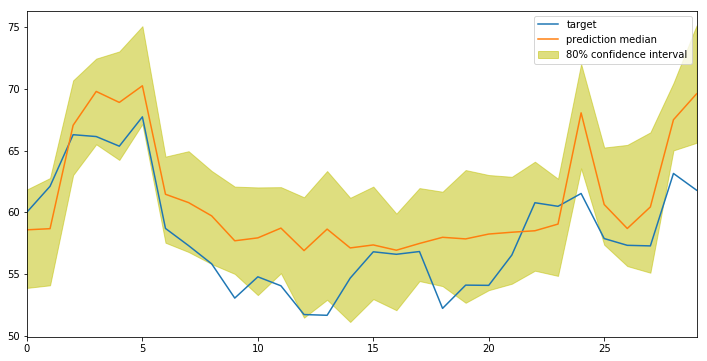

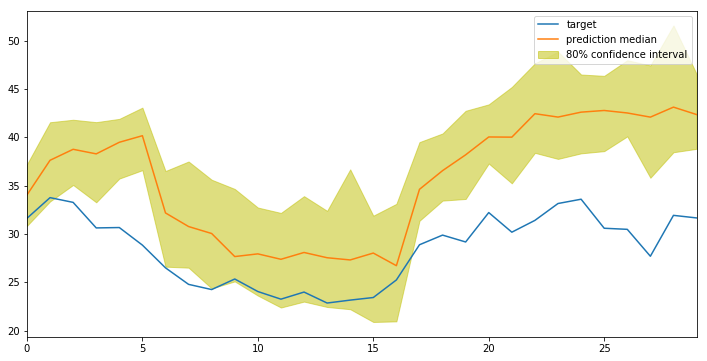

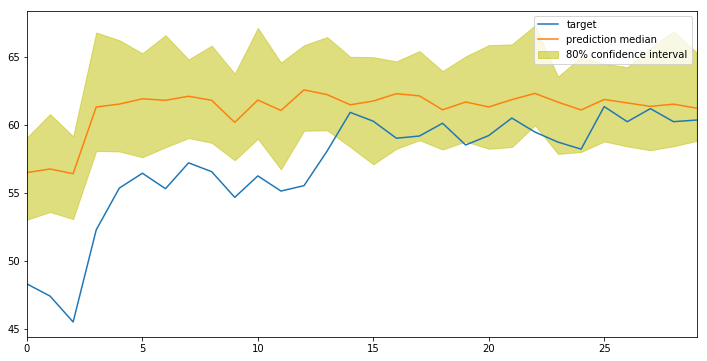

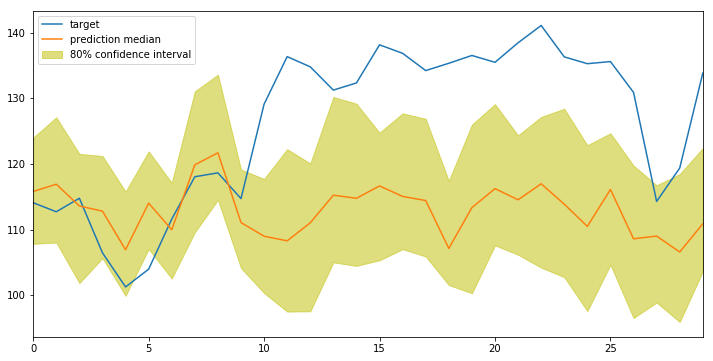

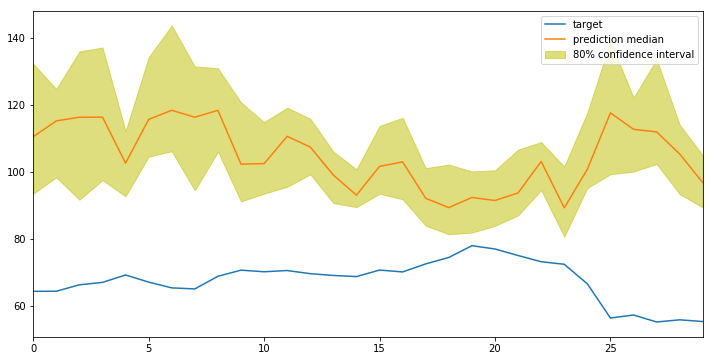

In [48]:
# display predictions
display_quantiles(prediction_list, target_ts=quarters)

In [49]:
# Starting my prediction at the beginning of 3rd quarter 2019
start_date = '2019-09-29'
timestamp = '00:00:00'

# formatting start_date
start_time = start_date +' '+ timestamp

ts_labels = ltc_3yr.columns.values[1:]
dynamic_feat = []
    
for i in range(len(ts_labels)):
    dynamic_feat.append(list(ltc_3yr['2019-09-29':'2019-10-29'][ltc_3yr.columns.values[i]]))

# formatting request_data
# this instance has an empty target!
request_data = {"instances": [{"start": start_time, "target": [], "dynamic_feat": dynamic_feat}],
                "configuration": {"num_samples": 50,
                                  "output_types": ["quantiles"],
                                  "quantiles": ['0.1', '0.5', '0.9']}
                }

json_input = json.dumps(request_data).encode('utf-8')

print('Requesting prediction for '+start_time)

Requesting prediction for 2019-09-29 00:00:00


In [50]:
# get prediction response
json_prediction = predictor.predict(json_input)

prediction_q4 = decode_prediction(json_prediction)


In [51]:
target_q4 = ltc_3yr['2019-09-29':'2019-10-28']

In [52]:
target_q4['Price']

date
2019-09-29    54.001144
2019-09-30    55.927208
2019-10-01    55.765906
2019-10-02    56.448218
2019-10-03    56.614479
2019-10-04    56.573141
2019-10-05    56.786484
2019-10-06    54.521839
2019-10-07    57.733823
2019-10-08    57.036728
2019-10-09    59.436602
2019-10-10    57.552446
2019-10-11    55.702243
2019-10-12    55.822620
2019-10-13    56.532920
2019-10-14    56.795286
2019-10-15    54.548698
2019-10-16    52.554284
2019-10-17    54.901029
2019-10-18    53.251189
2019-10-19    53.743133
2019-10-20    54.861684
2019-10-21    54.768957
2019-10-22    53.330875
2019-10-23    49.332035
2019-10-24    49.824631
2019-10-25    56.902924
2019-10-26    56.963597
2019-10-27    59.832752
2019-10-28    58.383654
Name: Price, dtype: float64

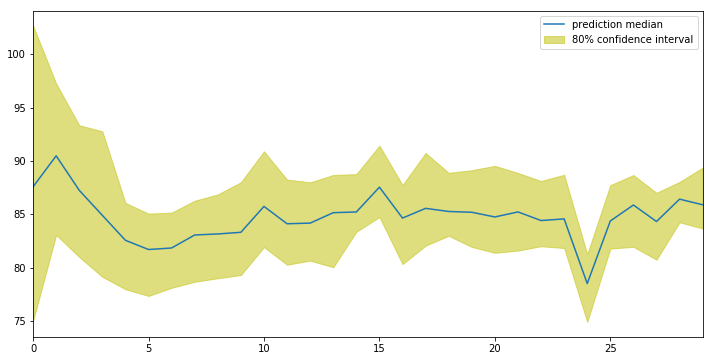

In [53]:
display_quantiles(prediction_q4)

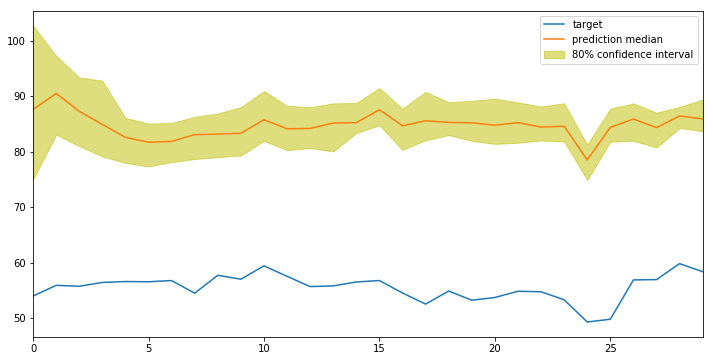

In [54]:
display_prediction_quantiles(prediction_q4, target_q4)

In [55]:
predictions = pd.DataFrame(prediction_q4[:][0])['0.5']
target = target_q4['Price']

In [56]:
roi_display(20000, predictions, target)

Investing $20000.00
Holding $20713.34
Investing $20713.34
Holding $21761.75
Investing $21761.75
Holding $21475.45
Investing $21475.45
Holding $20690.27
Investing $20690.27
Holding $21120.89
Investing $21120.89
Holding $20566.31
Investing $20566.31
Holding $23722.59
Investing $23722.59
Holding $24917.45
Total return on investment before taxes is $4917.45


In [57]:
get_test_loss(target, predictions)

29.21356668872249

In [58]:
predictor.delete_endpoint()